# Actividad 1
# Eliminación de anomalías en imágenes

## Autores:
- José Antonio Betances Vargas
- Jacobo Farray Rodríguez
- Pedro Alejandro González Morales
- Jean Michael Urday García

Ausente: José Enrique Cabrera Pérez

## Fecha de reuniones:

| Fecha | J. A. Betance Vargas | J. Farray Rodríguez | P. A. González Morales | J. M. Urday Garcia | J. E. Cabrera Pérez |
| -- | -- | -- | -- | -- | -- |
| 29.04.2021 | Ok | Ok | Ok | Ok | No |
| 02.05.2021 |Ok | Ok | Ok | Ok | No |
| 05.05.2021 |Ok | Ok | Ok | Ok | No |

## Descripción del problema

En este libro de Python se procede a corregir la anomalía de los ojos rojos en fotografías con flash.

## Solución propuesta

Para resolver esta anomalía se parte de un código de Python (Mallik, 2017) y de unas librerías de *OpenCV* (Github, 2020) como base.

Los pasos del proceso serían:

- Convertimos la imagen con la anomalía a escala de grises y detectamos caras (*cara*) y para cada cara detectamos ojos (*ojo*) usando un *Cascade* previamente entrenado.
- Crear una máscara:
    - Pasamos la imagen del ojo al espacio de colores *HSV* (HSL and HSV, 2021).
    - Usamos el canal de saturación (S) para, mediante un *sigma clipping* (Akhlaghi, 2021), quedarnos con los puntos por encima de un valor. Con *sigma_upper* controlamos cuantos múltiplos de la desviación estándar por encima de la media seleccionamos. 
    - Detectamos los contornos en la máscara para quedarnos con el de mayor área. Este contorno lo tomaremos como el de la pupila a corregir.
- Corrección de la pupila:
    - Descomponemos la imagen del ojo en los canales RGB. Desechamos el canal R ya que contiene información no deseada.
    - Reconstruimos el color de la pupila con la información restante, para ello calculamos la media de la suma de los canales B y G (*mean*)
    - Aplicamos la máscara sobre el promedio y separamos los canales RGB del resultado (*mean*)
    - Separamos la imagen de la máscara en los canales RGB (*mask2*)
    - La pupila corregida será el resultado de la operación *(mask2 & ojo) + mean* realizada punto a punto y para cada canal.
    
## Código

Se ofrece el código fuente comentado con varias imágenes de prueba. El código posee un parámetro de depuración (*debug=True/False*) que muestra información adicional del proceso.

Hemos decidido usar la media para realizar el *sigma clipping* en lugar de la mediana como sugiere *sigma clipping* (Akhlaghi, 2021) ya que en nuestras imágenes no tenemos zonas o puntos atípicos como es el caso de las imágenes astronómicas.

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [13]:
def main(imgName):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

    img = cv2.imread(imgName)

    # Imagen original
    img_original=img.copy()

    # Imagen para depuración
    img_debug=img.copy()

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Pasamos imagen a HSV porque en el canal S de saturación aparecen los colores saturados
    img_hsv  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 

    # Detectamos las posibles caras
    # Hemos probado distintos minNeighbors, hasta dar con el mejor (3)

    faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.3,minNeighbors=3)

    debug = False

    # Para cada cara... 
    for (x,y,w,h) in faces:

        if debug:
            # Recuadro para verificar detección de cara
            cv2.rectangle(img_debug,(x,y),(x+w,y+h),(255,0,0),1)

        # Cogemos la cara
        cara = img[y:y+h, x:x+w]
        cara_hsv  =  img_hsv[y:y+h, x:x+w]

        # Detectamos los ojos por cada cara
        ojos = eye_cascade.detectMultiScale(cara,scaleFactor=1.3, minNeighbors=4)

        for (ex,ey,ew,eh) in ojos:

            ojo = cara[ey:ey+eh, ex:ex+ew].astype(np.uint8)
            ojo_hsv  =  cara_hsv[ey:ey+eh, ex:ex+ew].astype(np.uint8) # peter


            # --> Mascara HSV:
            # En el canal S (saturación) el ojo rojo destaca bastante y es mas facil hacer la máscara.
            # La máscara la creamos desechando los valores por encima de un cierto valor
            # mediante un sigma_clipping.

            h, s, v = cv2.split(ojo_hsv)

            # Número de sigmas por encima de la media
            sigma_upper = 1.5 
            # Creamos máscara
            mask  = (s>(np.mean(s)+sigma_upper*np.std(s))).astype(np.uint8)*255

            # Buscamos los contornos posibles en la máscara
            contours, _ = cv2. findContours(mask.copy() ,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )

            # Nos quedamos con el contorno con la mayor área
            maxArea = 0
            maxCont = None
            for cont in contours:
                area = cv2.contourArea(cont)
                if area > maxArea:
                    maxArea = area
                    maxCont = cont


            # Ponemos máscara a cero
            mask = mask * 0  

            # Ensanchamos la máscara un pixel para evitar bordes abruptos
            cv2.drawContours(mask , [maxCont],0 ,(255),-1 )
            mask = cv2.dilate(mask, None, anchor=(-1, -1), iterations=1, borderType=1, borderValue=1)

            # Dividimos el ojo en canales RGB
            b, g ,r = cv2.split(ojo) 
            # Sumamos canales Azul y Verde 
            bg = cv2.add(b,g)

            # Sacamos promedio int de Azul y Verde
            mean  = bg //2

            # Obtenemos la textura de la pupila, mediante el promedio sobre la máscara
            mean = cv2.bitwise_and(mean , mask )  
            # Convertimos a 3 canales el promedio (lo que desatura la pupila)
            mean = cv2.cvtColor(mean ,cv2.COLOR_GRAY2BGR ) 
            # Convertimos a 3 canales la máscara
            mask2 = cv2.cvtColor(mask ,cv2.COLOR_GRAY2BGR )  

            # Colocamos la pupila en cero, y sobre ella dibujamos la textura desaturada de la pupila
            eye = cv2.bitwise_and(~mask2,ojo)+mean           

            if debug:
                # Dibujamos máscara solo para depurar
                img_debug[y+ey:y+ey+eh, x+ex:x+ex+ew] = np.repeat(np.expand_dims(mask,axis=2),3, axis=2)

            # Reemplazamos ojo para imagen corregida
            img[y+ey:y+ey+eh, x+ex:x+ex+ew] =  eye


            if debug:
                # Imprimo y dibujo cosas
                print("Number of Contours is: " + str(len(contours)))
                # cv2.drawContours(img, contours, 0, (0, 230, 255), 1)
                print("- Estadistica (bg) :: mean,std,median")
                print(np.mean(bg),np.std(bg),np.median(bg))
                print("- Estadistica (r) :: mean,std,median")
                print(np.mean(r),np.std(r),np.median(r))
                print("- Estadistica (s) :: mean,std,median")
                print(np.mean(s),np.std(s),np.median(s))        
                print("Plot r,g,b :: bg :: h,s,v :: mask")
                plt.figure(figsize=(10,10))
                plt.imshow(np.hstack([r,g,b,bg,h,s,v,mask]))
                plt.show()

    if debug:
        image=cv2.cvtColor(np.hstack([img_original,img_debug,img]),cv2.COLOR_BGR2RGB)  
    else:
        image=cv2.cvtColor(np.hstack([img_original,img]),cv2.COLOR_BGR2RGB)  

    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()



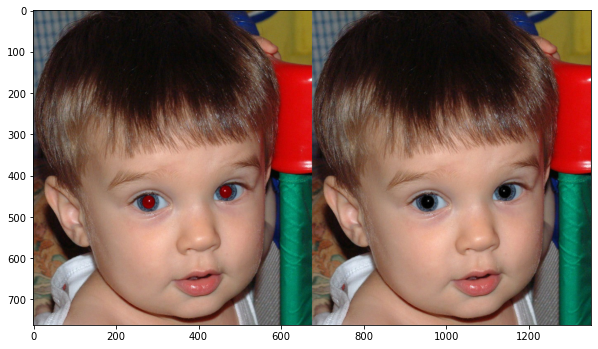

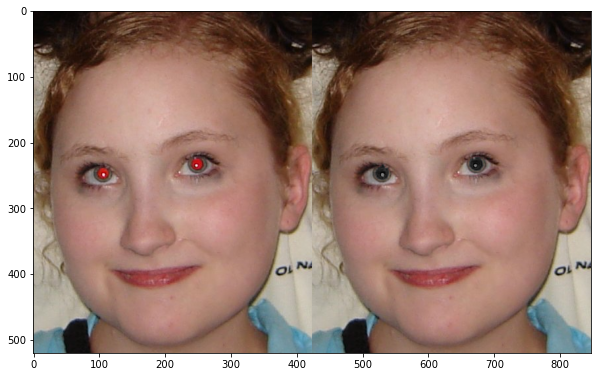

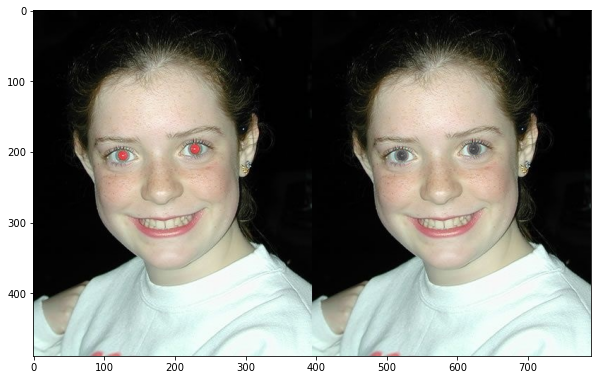

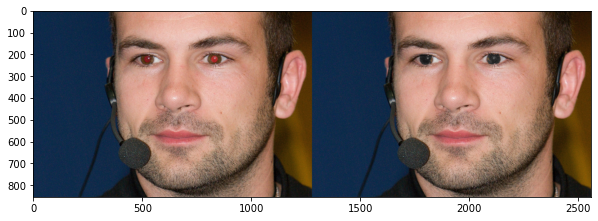

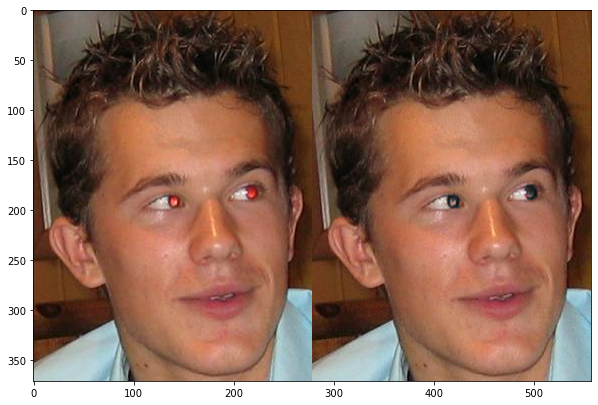

In [14]:
main('foto1.jpg') # Véase Farr, 2015.
main('foto2.jpg') # Véase Mallick, 2017.
main('foto3.jpg') # Véase Kimbrough, s. f.
main('foto4.jpg') # Véase Home Photo Studio, s. f.
main('foto5.jpg') # Véase Oscpics, s. f.

## Conclusiones

Este código supone una mejora a la fuente originaria (Mallick, 2017). Es posible aplicar a diferentes imagenes con las misma anomalías. No obstante, las fotos con caras notablemente inclinadas supondrían un problema para la solución propuesta. Lo mismo sucede con imágenes con colores rojos repartidos a lo largo de las misma.

## Mejoras

La solución propuesta se puede mejorar en aspectos como:
- Detección de caras no orientadas verticalmente
- Detección de ojos, los cuales pertenecen a caras que no están completas en la foto

## Referencias


Akhlaghi, M. (2021). *GNU Astronomy Utilities* (cap. 7.1.3, pp. 271-272). Free Software Foundation. https://www.gnu.org/software/gnuastro/manual

Farr, M. (2015, septiembre 03). Red Eye. En *6iee.com*. Recuperado el 3 de mayo de 2021 en http://6iee.com/649892.html

Github. (2020, abril 13). *Haarcascades*. Recuperado el 3 de mayo de https://github.com/opencv/opencv/tree/master/data/haarcascades

Home Photo Studio (s. f.). *How to Remove Red Eyes from Photos*. Recuperado el 3 de mayo de https://home-photo-studio.com/how-to-remove-red-eyes-from-photos.php

HSL and HSV. (2021, mayo 1). En *Wikipedia*. https://en.wikipedia.org/w/index.php?title=HSL_and_HSV&oldid=1020916226

Kimbrough, E. (s. f.). What would happen if our eyes did not have a choroid layer?. En *Quora*. Recuperado el 3 de mayo de 2021 de https://www.quora.com/What-would-happen-if-our-eyes-did-not-have-a-choroid-layer

Mallick, S. (2017, marzo 7). *Automatic Red Eye Remover using OpenCV (C++ / Python)*. https://learnopencv.com/automatic-red-eye-remover-using-opencv-cpp-python/

Oscpics. (s. f.). *OscPics Services*. Recuperado el 3 de mayo de http://www.oscpics.com/Services/Index.html

Pngkit. (s. f.). *Get Rid Of Red Eyes In Photo - People With Red Eye*. Recuperado el 3 de mayo de 2021 de https://www.pngkit.com/bigpic/u2e6y3u2y3y3y3a9/